In [48]:

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import matplotlib.animation as anim
from tqdm import tqdm

In [49]:
#Asignar constantes del sistema
G = 6.67e-11
MT = 5.9736e24
ML = 0.07349e24
dTL = 3.844e8
w = 2.6617e-6
RT = 6.37816e6
RL = 1.7374e6

In [50]:
def System(coord,t):

    Pr, P_phi,r, phi = coord
    Delta = G*MT/dTL**3
    miu = ML/MT
    r_prima = np.sqrt(1 + r**2 - 2*r*np.cos(phi-w*t))

    drdt = Pr
    dphidt = P_phi/r**2
    dPrdt = P_phi**2/r**3 - Delta*(1/r**2 + (miu/r_prima**3)*(r - np.cos(phi-w*t)))
    dP_phidt = -Delta*miu*r/(r_prima**3)*np.sin(phi-w*t)

    return np.array([dPrdt, dP_phidt, drdt, dphidt])

In [51]:
def Increment(f,r,t,h):
    
    state1 = np.array([r[0],r[1],r[2],r[3]])
    K1 = f(state1,t)
    
    state2 = np.array([r[0]+0.5*h*K1[0],r[1]+0.5*h*K1[1],r[2]+0.5*h*K1[2],r[3]+0.5*h*K1[3]])
    K2 = f(state2,t+0.5*h)
    
    state3 = np.array([r[0]+0.5*h*K2[0],r[1]+0.5*h*K2[1],r[2]+0.5*h*K2[2],r[3]+0.5*h*K2[3]])
    K3 = f(state3,t+0.5*h)
    
    state4 = np.array([r[0]+h*K3[0],r[1]+h*K3[1],r[2]+h*K3[2],r[3]+h*K3[3]])
    K4 = f(state4, t+h)
    
    Deltaf = h*(K1+2*K2+2*K3+K4)/6
    
    return r+Deltaf

In [52]:
def Adaptativo(f,r0,t,e=1e-4):
    
    h = t[1] - t[0]
    
    tf = t[-1]
    t = t[0]
    
    r = r0
    
    Time = np.array([t])
    Vector = r 
    Steps = np.array([h])

    while t < tf:
        
        Delta1 = Increment(f,r,t,h)
        Delta2 = Increment(f,Delta1,t+h,h)
        Delta3 = Increment(f,r,t,2*h)
 
        error=  np.linalg.norm(Delta2- Delta3)
        
        if error < e:
                t += 2*h
                r = Delta3       
                Steps = np.append(Steps,h )
                Time = np.append(Time,t)
                Vector = np.vstack((Vector,r))
                
 

 
        z = 0.85*(e/error)**(1/4)
        h = h*z

 

              
        
    return Time,Vector

In [53]:
t = np.arange(0.,1e6,1)
v0 = 11.1e3/dTL
phi0 = 0*np.pi/180
theta0 = 30*np.pi/180
r0 = RT/dTL
Pr, p_phi=( v0*np.cos(theta0-phi0), v0*r0*np.sin(theta0-phi0))
coord = [Pr, p_phi, r0, phi0]

In [54]:
adap = Adaptativo(System,coord,t)
tsol = adap[0]
print('Total de pasos: ', len(tsol))
sol = adap[1]
#Establecer coordenadas x y y de la luna y el satelite
xL = dTL*np.cos(w*tsol)
yL = dTL*np.sin(w*tsol)
xS = sol[:,2]*np.cos(sol[:,3])*dTL
yS = sol[:,2]*np.sin(sol[:,3])*dTL

Total de pasos:  96


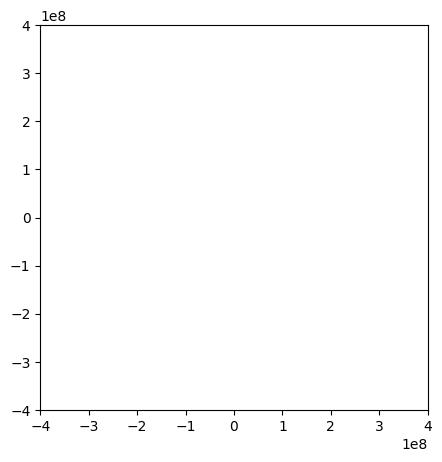

In [55]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
T = tsol*(1/86400)

def init():
    
    ax.clear()
    ax.set_xlim(-4e8,4e8)
    ax.set_ylim(-4e8,4e8)
    
def Update(i):
    
    init()
        
    ax.scatter(xL[i], yL[i], color='k')
    ax.scatter(0,0, color='b')
    ax.set_title("t = {:.4f} dias terrestres".format(T[i]))
    ax.scatter(xS[i],yS[i], color='red')
    
        
        
Animation = anim.FuncAnimation(fig,Update,frames=len(tsol),init_func=init)

In [56]:
Animation.save('ViajeLunaAdap.gif', writer='pillow')